# Training an approximate GP with derivatives

In this notebook, we will train an approximate GP with function values and derivatives, although at different locations. 

In [11]:
import torch
import gpytorch
import math
from matplotlib import pyplot as plt
import numpy as np

First we create the training data from a sine function with some added noise. Importantly, the function observations and the derivative observations are at different locations.

In [12]:
lb, ub = 0., 1. 
freq = 0.4 #frequency of the size function

n1 = 40 #function values
train_x1 = torch.linspace(lb, ub, n1)#.unsqueeze(-1)
train_y1 = torch.sin(freq*train_x1) + 0.005 * torch.randn(train_x1.size())

n2=50 #derivative values at different x locations
train_x2 = torch.linspace(lb, ub, n2)#.unsqueeze(-1)
train_y2 = freq*torch.cos(freq*train_x2) + 0.005 * torch.randn(train_x2.size())

train_x = torch.cat([train_x1 , train_x2])
train_y = torch.cat([train_y1,train_y2])

ndata,ndim = train_x.shape.numel(),1

Since the model needs to differentiate between the two types of locations, we crate an array of boolean indices of shape `ndata,ndim+1` that indicate what observations are at each element of `train_x` (i.e., we allow one location to have both function and derivative observations)

In [13]:
train_index = torch.empty(ndata,ndim+1,dtype=bool)
train_index[:n1,0]=True
train_index[:n1,1]=False
train_index[n1:,0]=False
train_index[n1:,1]=True

Next, we define an Approximate GP with Cholesky Variational distribution and the indexed version of the `VariationalStrategy`, called `VariationalStrategyIndexed`

In [14]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategyIndexed

class GPModel(ApproximateGP):
    def __init__(self):
        inducing_points = torch.rand(40)*ub
        inducing_index = torch.ones(40,ndim+1,dtype=bool)
        variational_distribution = CholeskyVariationalDistribution(torch.sum(inducing_index).item())
        variational_strategy = VariationalStrategyIndexed(
            self, inducing_points, variational_distribution, inducing_index, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernelGrad())

    def forward(self, x, index):
        index = index.reshape(-1)
        mean_x = self.mean_module(x).reshape(-1)[index]
        full_kernel = self.covar_module(x)
        covar_x = full_kernel[..., index,:][...,:,index]
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

[Because of a bug in the `linear_operator` ](https://github.com/cornellius-gp/gpytorch/issues/1554), we have to unset its debug option. Otherwise, it raises an error while slicing the covariance matrix.

In [15]:
gpytorch.linear_operator.settings.debug._default = False

We crate instances of the model and a Gaussian likelihood. 

In [16]:
model = GPModel()
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# "Loss" for approximate GPs - the ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

Next, we train the GP using Adam optimizer. The main difference from the default ApproximateGP is that we have to pass named argument `x_index` when calling the model.

In [17]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x,x_index=train_index)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.614
Iter 2/50 - Loss: 1.410
Iter 3/50 - Loss: 1.076
Iter 4/50 - Loss: 1.013
Iter 5/50 - Loss: 1.011
Iter 6/50 - Loss: 0.946
Iter 7/50 - Loss: 0.863
Iter 8/50 - Loss: 0.815
Iter 9/50 - Loss: 0.801
Iter 10/50 - Loss: 0.786
Iter 11/50 - Loss: 0.746
Iter 12/50 - Loss: 0.691
Iter 13/50 - Loss: 0.640
Iter 14/50 - Loss: 0.603
Iter 15/50 - Loss: 0.573
Iter 16/50 - Loss: 0.534
Iter 17/50 - Loss: 0.481
Iter 18/50 - Loss: 0.421
Iter 19/50 - Loss: 0.365
Iter 20/50 - Loss: 0.320
Iter 21/50 - Loss: 0.278
Iter 22/50 - Loss: 0.233
Iter 23/50 - Loss: 0.183
Iter 24/50 - Loss: 0.134
Iter 25/50 - Loss: 0.086
Iter 26/50 - Loss: 0.037
Iter 27/50 - Loss: -0.010
Iter 28/50 - Loss: -0.060
Iter 29/50 - Loss: -0.115
Iter 30/50 - Loss: -0.167
Iter 31/50 - Loss: -0.219
Iter 32/50 - Loss: -0.270
Iter 33/50 - Loss: -0.321
Iter 34/50 - Loss: -0.375
Iter 35/50 - Loss: -0.428
Iter 36/50 - Loss: -0.481
Iter 37/50 - Loss: -0.532
Iter 38/50 - Loss: -0.583
Iter 39/50 - Loss: -0.637
Iter 40/50 - Loss: -0

The trained model and its derivatives are plotted next

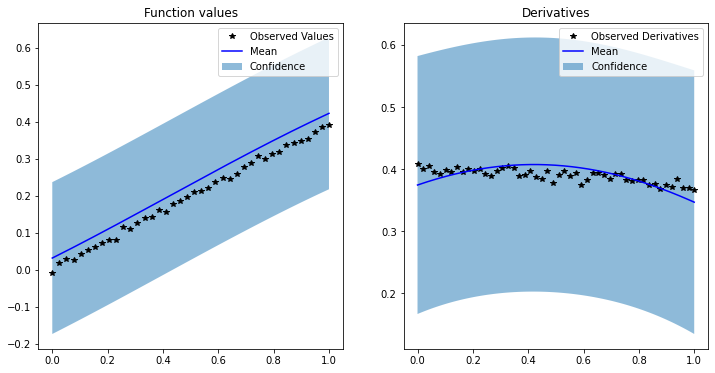

In [18]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(12, 6))

n11=200
test_x = torch.linspace(lb, ub, n11)
test_index = torch.ones(test_x.shape[0],ndim+1,dtype=bool)

# Make predictions
with torch.no_grad(), gpytorch.settings.max_cg_iterations(50):
    predictions = likelihood(model(test_x,x_index=test_index))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# Plot training data as black stars
y1_ax.plot(train_x[:n1].detach().numpy(), train_y[:n1].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.detach().numpy(), mean[::2].detach().numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.detach().numpy(), lower[::2].detach().numpy(), upper[::2].detach().numpy(), alpha=0.5)
y1_ax.legend(['Observed Values', 'Mean', 'Confidence'])
y1_ax.set_title('Function values')

# Plot training data as black stars
y2_ax.plot(train_x[n1:].detach().numpy(), train_y[n1:].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.detach().numpy(), mean[1::2].detach().numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.detach().numpy(), lower[1::2].detach().numpy(), upper[1::2].detach().numpy(), alpha=0.5)
y2_ax.legend(['Observed Derivatives', 'Mean', 'Confidence'])
y2_ax.set_title('Derivatives')

plt.show()

# Monotonic GP
In general, they do not have to be the same. This can be achieved implementing a `CompositeLikelihood` demonstrated in this section. We use the `CompositeLikelihood` to create a monotonic GP following the approach by [Riihimaki and Vehtari](http://proceedings.mlr.press/v9/riihimaki10a/riihimaki10a.pdf). A Gaussian likelihood is used for the function values, but a probit likelihood, called `BernoulliLikelihood` in `gpytorch`, is used to constrain derivatives to be positive. Here a parameter `nu` defines a scaling factor, and increasing this factor increases the accuracy of the constraint.

In [26]:
class CompositeLikelihood(gpytorch.likelihoods._OneDimensionalLikelihood):
    def __init__(self,likelihoods_list,indices):
        super().__init__()
        self.likelihoods_list = likelihoods_list
        self.indices = indices
        self.nu = 1.

    def set_indices(indices):
        self.indices = indices

    def forward(self,function_samples,**kwargs):
        #This method is not called for ELBO, so it does not need to be implemented
        raise NotImplementedError

    def split(self, full_y):
        y = []
        temp = torch.zeros_like(self.indices)
        #print(full_y)
        for i in range(self.indices.shape[-1]):
            temp[:,i] = self.indices[:,i]
            y.append(full_y[...,temp[self.indices]])
            temp[:,i] = False
        return y

    def expected_log_prob(self,observations, function_dist, *params,**kwargs):
        #split observations into a list of different parts observ[i]
        observ = self.split(observations)

        def log_prob_lambda(function_samples):
            #for the log_prob_lambda function, which takes function_samples as input
            #split the function_samples into a list of different parts f_samples[i]
            f_samples = self.split(function_samples)
            log_prob = []
            for i,l in enumerate(self.likelihoods_list):
                if isinstance(l,gpytorch.likelihoods.GaussianLikelihood):
                    log_prob.append(l(f_samples[i]).log_prob(observ[i]))
                elif isinstance(l,gpytorch.likelihoods.BernoulliLikelihood):
                    log_prob.append(gpytorch.functions.log_normal_cdf(
                        f_samples[i].mul(observ[i].mul(2).sub(1)).mul(self.nu))) 
                    #.mul(2).sub(1) changes the Bernoulli observations to -1 and 1, 
                    #so that p(Y=y|f)=\Phi(yf), see the BernoulliLikelihood) for details on this

            #combine the log_prob back into the correct ordered full vector
            return torch.cat(log_prob,-1)

        log_prob = self.quadrature(log_prob_lambda, function_dist)
        return log_prob

Having this likelihood function, we set a similar problem to above. However, in this case, there are no actual observations at the derivative locations. Instead, the `train_y2` is 1 at the derivative locations, which indicates that the derivatives must be positive.

In [20]:
lb, ub = 0.0, 1. 
n1 = 40 #function values
freq = 2 #frequency of the size function
train_x1 = torch.linspace(lb, ub, n1)
train_y1 = torch.sin(freq*train_x1) + 0.005 * torch.randn(train_x1.size())

n2=50 #derivative values at different x locations
train_x2 = torch.linspace(lb, ub, n2)
train_y2 = torch.ones_like(train_x2) 

train_x = torch.cat([train_x1 , train_x2])
train_y = torch.cat([train_y1,train_y2])

ndata,ndim = train_x.shape.numel(),1
train_index = torch.empty(ndata,ndim+1,dtype=bool)
train_index[:n1,0]=True
train_index[:n1,1]=False
train_index[n1:,0]=False
train_index[n1:,1]=True

We create an instance of the `GPModel` and create two likelihood functions -- one for function values and one for derivatives -- and pass these onto the `CompositeLikelihood` along with the indices at the training points `train_index`. ELBO is used for the loss function. 

In [21]:
gpytorch.linear_operator.settings.debug._default = False
model = GPModel()
likelihood  = gpytorch.likelihoods.GaussianLikelihood()
likelihood2 = gpytorch.likelihoods.BernoulliLikelihood()
test_likelihood = CompositeLikelihood((likelihood,likelihood2),train_index)
mll = gpytorch.mlls.VariationalELBO(test_likelihood, model, num_data=train_y.size(0))

Next we train the model, first with default `nu` of 1 and then increase `nu` to 10 and train for another 500 iterations. 

In [24]:
# Find optimal model hyperparameters
model.train()
test_likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

training_iter = 2 if smoke_test else 500

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x,x_index=train_index)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()
    
#increase the nu and train again
test_likelihood.nu = 10.
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x,x_index=train_index)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/500 - Loss: -0.350
Iter 2/500 - Loss: 5.153
Iter 3/500 - Loss: -0.105
Iter 4/500 - Loss: 1.501
Iter 5/500 - Loss: 2.501
Iter 6/500 - Loss: 1.507
Iter 7/500 - Loss: 0.269
Iter 8/500 - Loss: -0.196
Iter 9/500 - Loss: 0.071
Iter 10/500 - Loss: 0.480
Iter 11/500 - Loss: 0.591
Iter 12/500 - Loss: 0.387
Iter 13/500 - Loss: 0.083
Iter 14/500 - Loss: -0.138
Iter 15/500 - Loss: -0.212
Iter 16/500 - Loss: -0.167
Iter 17/500 - Loss: -0.076
Iter 18/500 - Loss: -0.004
Iter 19/500 - Loss: 0.019
Iter 20/500 - Loss: -0.008
Iter 21/500 - Loss: -0.068
Iter 22/500 - Loss: -0.138
Iter 23/500 - Loss: -0.197
Iter 24/500 - Loss: -0.229
Iter 25/500 - Loss: -0.231
Iter 26/500 - Loss: -0.210
Iter 27/500 - Loss: -0.185
Iter 28/500 - Loss: -0.171
Iter 29/500 - Loss: -0.175
Iter 30/500 - Loss: -0.193
Iter 31/500 - Loss: -0.217
Iter 32/500 - Loss: -0.237
Iter 33/500 - Loss: -0.250
Iter 34/500 - Loss: -0.255
Iter 35/500 - Loss: -0.254
Iter 36/500 - Loss: -0.250
Iter 37/500 - Loss: -0.245
Iter 38/500 - Loss: -

Iter 299/500 - Loss: -0.675
Iter 300/500 - Loss: -0.678
Iter 301/500 - Loss: -0.682
Iter 302/500 - Loss: -0.686
Iter 303/500 - Loss: -0.689
Iter 304/500 - Loss: -0.694
Iter 305/500 - Loss: -0.696
Iter 306/500 - Loss: -0.702
Iter 307/500 - Loss: -0.703
Iter 308/500 - Loss: -0.709
Iter 309/500 - Loss: -0.710
Iter 310/500 - Loss: -0.715
Iter 311/500 - Loss: -0.717
Iter 312/500 - Loss: -0.721
Iter 313/500 - Loss: -0.724
Iter 314/500 - Loss: -0.727
Iter 315/500 - Loss: -0.730
Iter 316/500 - Loss: -0.733
Iter 317/500 - Loss: -0.736
Iter 318/500 - Loss: -0.739
Iter 319/500 - Loss: -0.742
Iter 320/500 - Loss: -0.744
Iter 321/500 - Loss: -0.747
Iter 322/500 - Loss: -0.749
Iter 323/500 - Loss: -0.752
Iter 324/500 - Loss: -0.754
Iter 325/500 - Loss: -0.756
Iter 326/500 - Loss: -0.759
Iter 327/500 - Loss: -0.760
Iter 328/500 - Loss: -0.762
Iter 329/500 - Loss: -0.765
Iter 330/500 - Loss: -0.766
Iter 331/500 - Loss: -0.768
Iter 332/500 - Loss: -0.770
Iter 333/500 - Loss: -0.771
Iter 334/500 - Loss:

Iter 96/500 - Loss: -0.753
Iter 97/500 - Loss: -0.764
Iter 98/500 - Loss: -0.763
Iter 99/500 - Loss: -0.765
Iter 100/500 - Loss: -0.770
Iter 101/500 - Loss: -0.768
Iter 102/500 - Loss: -0.775
Iter 103/500 - Loss: -0.773
Iter 104/500 - Loss: -0.778
Iter 105/500 - Loss: -0.778
Iter 106/500 - Loss: -0.782
Iter 107/500 - Loss: -0.782
Iter 108/500 - Loss: -0.785
Iter 109/500 - Loss: -0.786
Iter 110/500 - Loss: -0.788
Iter 111/500 - Loss: -0.791
Iter 112/500 - Loss: -0.790
Iter 113/500 - Loss: -0.795
Iter 114/500 - Loss: -0.792
Iter 115/500 - Loss: -0.798
Iter 116/500 - Loss: -0.795
Iter 117/500 - Loss: -0.799
Iter 118/500 - Loss: -0.799
Iter 119/500 - Loss: -0.800
Iter 120/500 - Loss: -0.802
Iter 121/500 - Loss: -0.802
Iter 122/500 - Loss: -0.804
Iter 123/500 - Loss: -0.805
Iter 124/500 - Loss: -0.805
Iter 125/500 - Loss: -0.807
Iter 126/500 - Loss: -0.807
Iter 127/500 - Loss: -0.807
Iter 128/500 - Loss: -0.809
Iter 129/500 - Loss: -0.808
Iter 130/500 - Loss: -0.809
Iter 131/500 - Loss: -0.

Iter 394/500 - Loss: -0.414
Iter 395/500 - Loss: -0.686
Iter 396/500 - Loss: -0.808
Iter 397/500 - Loss: -0.666
Iter 398/500 - Loss: -0.674
Iter 399/500 - Loss: -0.807
Iter 400/500 - Loss: -0.727
Iter 401/500 - Loss: -0.737
Iter 402/500 - Loss: -0.803
Iter 403/500 - Loss: -0.733
Iter 404/500 - Loss: -0.791
Iter 405/500 - Loss: -0.772
Iter 406/500 - Loss: -0.768
Iter 407/500 - Loss: -0.797
Iter 408/500 - Loss: -0.763
Iter 409/500 - Loss: -0.800
Iter 410/500 - Loss: -0.773
Iter 411/500 - Loss: -0.794
Iter 412/500 - Loss: -0.786
Iter 413/500 - Loss: -0.787
Iter 414/500 - Loss: -0.796
Iter 415/500 - Loss: -0.784
Iter 416/500 - Loss: -0.801
Iter 417/500 - Loss: -0.787
Iter 418/500 - Loss: -0.801
Iter 419/500 - Loss: -0.794
Iter 420/500 - Loss: -0.797
Iter 421/500 - Loss: -0.802
Iter 422/500 - Loss: -0.795
Iter 423/500 - Loss: -0.805
Iter 424/500 - Loss: -0.799
Iter 425/500 - Loss: -0.804
Iter 426/500 - Loss: -0.805
Iter 427/500 - Loss: -0.802
Iter 428/500 - Loss: -0.808
Iter 429/500 - Loss:

Lastly, we plot the resulting trained GP and its derivatives. Due to the constraints, the posterior mean does not decrease, and instead becomes flat.

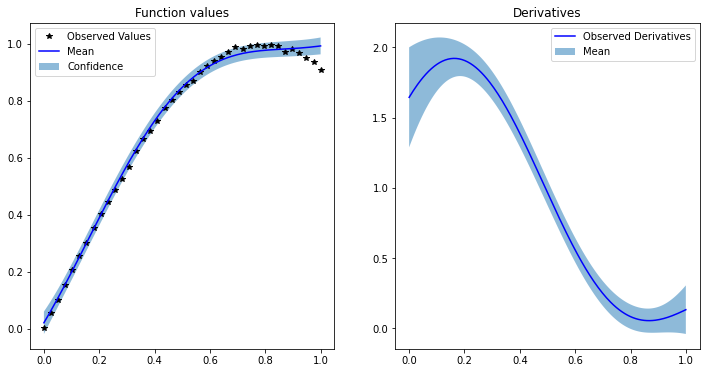

In [25]:
model.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(12, 6))

n11=200
test_x = torch.linspace(lb, ub, n11)
test_index = torch.ones(test_x.shape[0],ndim+1,dtype=bool)

# Make predictions
with torch.no_grad(), gpytorch.settings.max_cg_iterations(50):
    predictions = model(test_x,x_index=test_index)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# Plot training data as black stars
y1_ax.plot(train_x[:n1].detach().numpy(), train_y[:n1].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.detach().numpy(), mean[::2].detach().numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.detach().numpy(), lower[::2].detach().numpy(), upper[::2].detach().numpy(), alpha=0.5)
y1_ax.legend(['Observed Values', 'Mean', 'Confidence'])
y1_ax.set_title('Function values')

# Predictive mean as blue line
y2_ax.plot(test_x.detach().numpy(), mean[1::2].detach().numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.detach().numpy(), lower[1::2].detach().numpy(), upper[1::2].detach().numpy(), alpha=0.5)
y2_ax.legend(['Observed Derivatives', 'Mean', 'Confidence'])
y2_ax.set_title('Derivatives')

plt.show()